In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import predeltascuti
from astronn.datasets import deltascuti, starmodels
from astronn import models

import tensorflow as tf
import numpy as np
import shap

import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess eleven delta scuti stars
#preprocessor = predeltascuti()
#preprocessor.preprocess_files(
#    input_folder="../../astronn/data/deltascuti/raw/*",
#    output_folder="../../astronn/data/deltascuti/preprocessed/",
#)

#### Utils functions

In [3]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

In [4]:
# Load best model.
sepconv_mod = tf.keras.models.load_model(
    "/home/roberto/Projects/asteroseismologyNN/models/model_dnu_noisy.h5",
    custom_objects={"rec_at_2": top_2_categorical_accuracy,
                    "rec_at_4": top_4_categorical_accuracy,
                    "recat_6": top_6_categorical_accuracy,
                    "rec_at_8": top_8_categorical_accuracy}
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Process 11 ds stars, infer Dnu and calculate shap values explanations

ed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
[[76 80 81 79 82 88 78 77 86 85]]
[[23 21 20 22 26 25 24 27 29 28]]
[[21 22 20 23 25 24 27 28 29 26]]


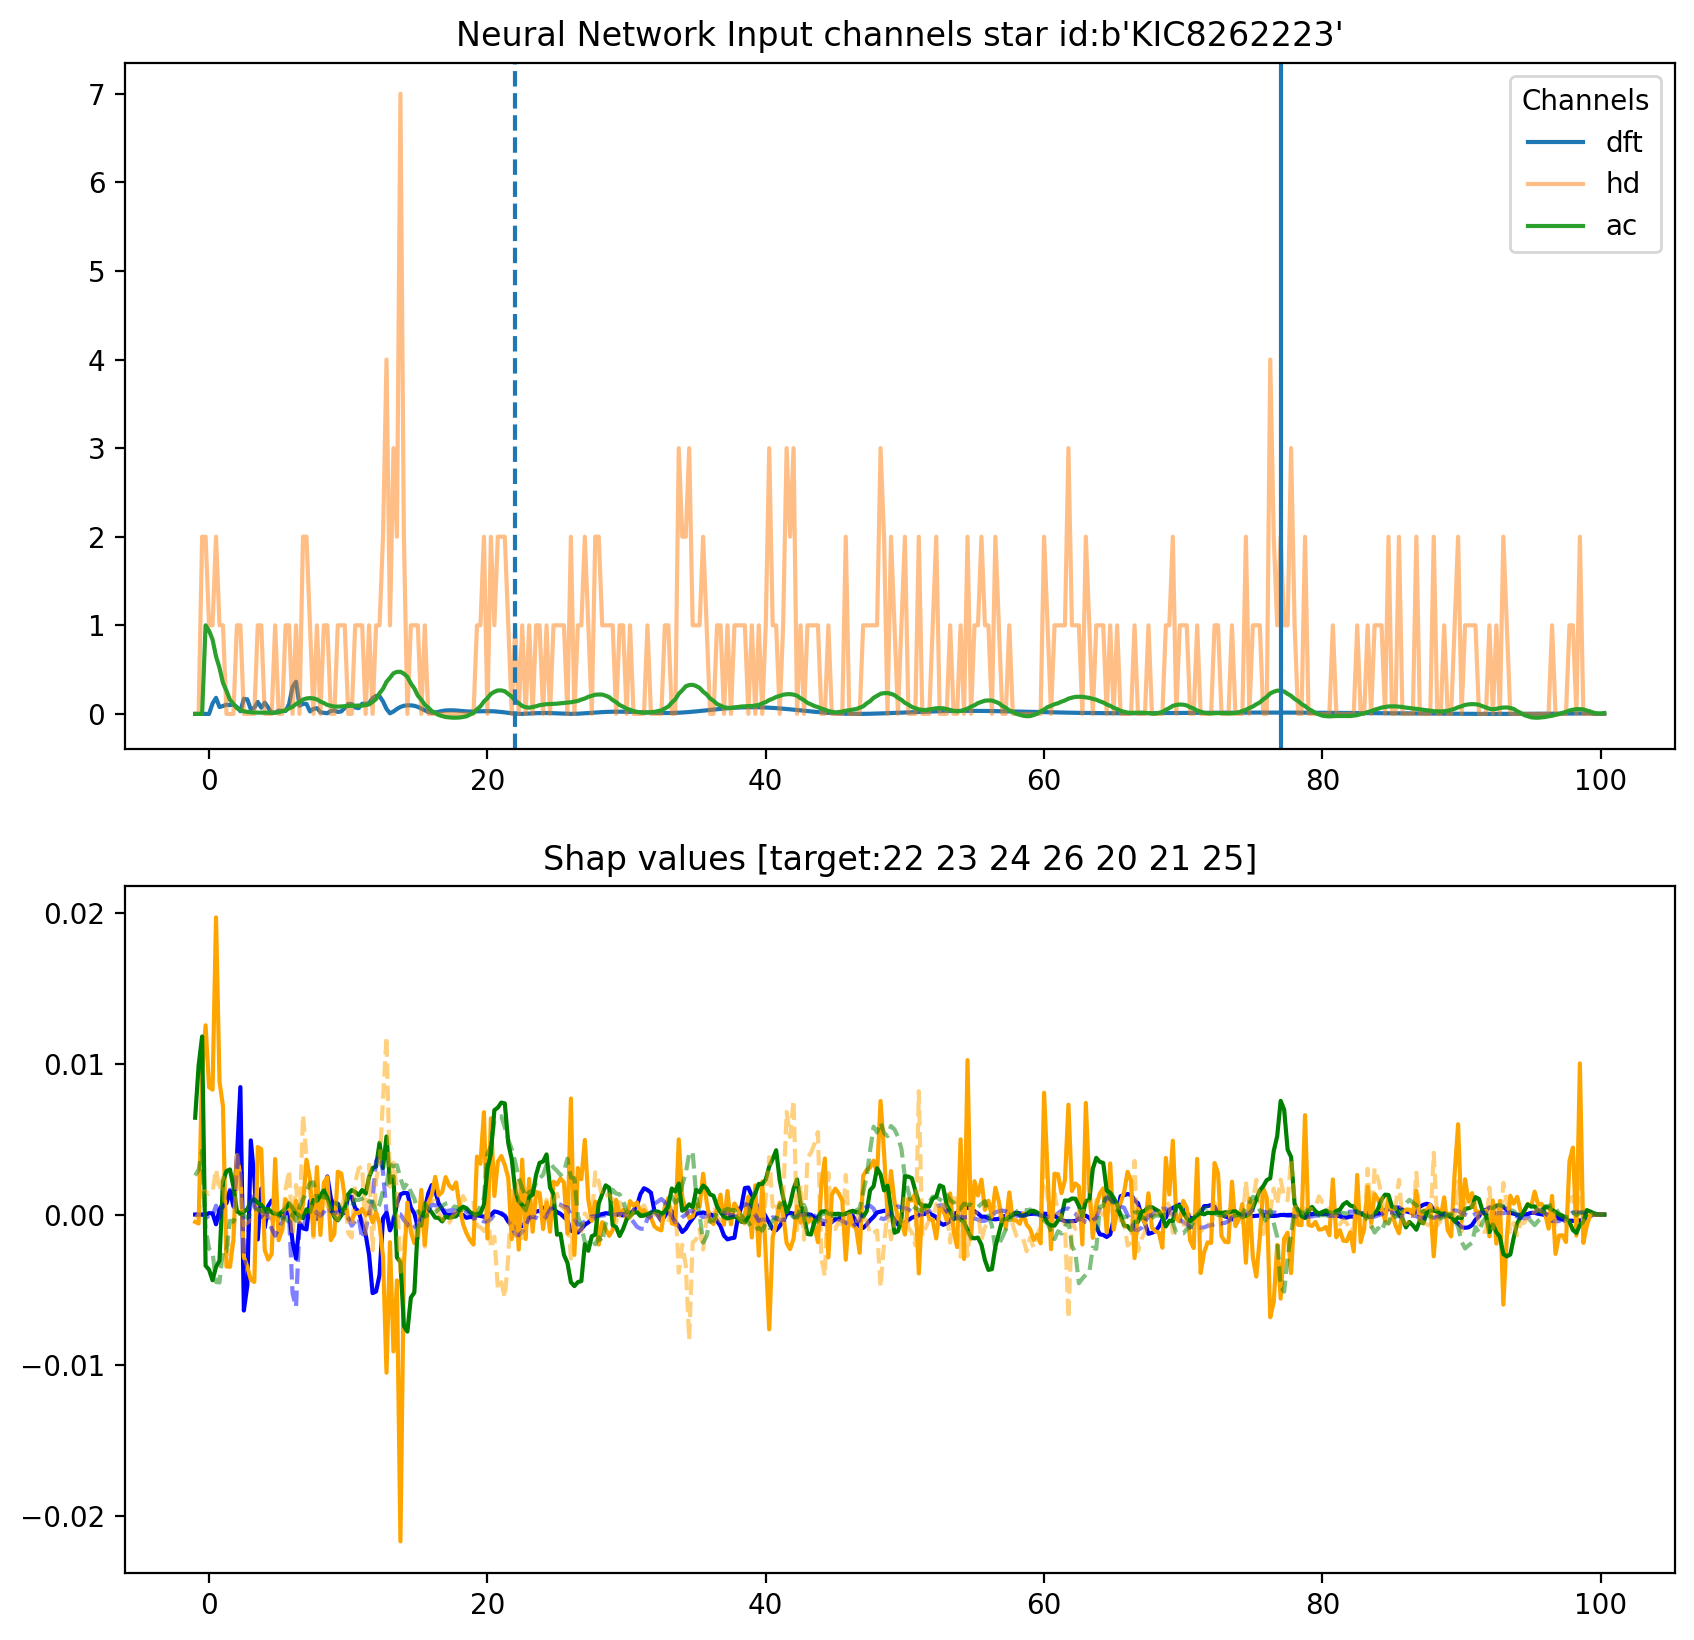

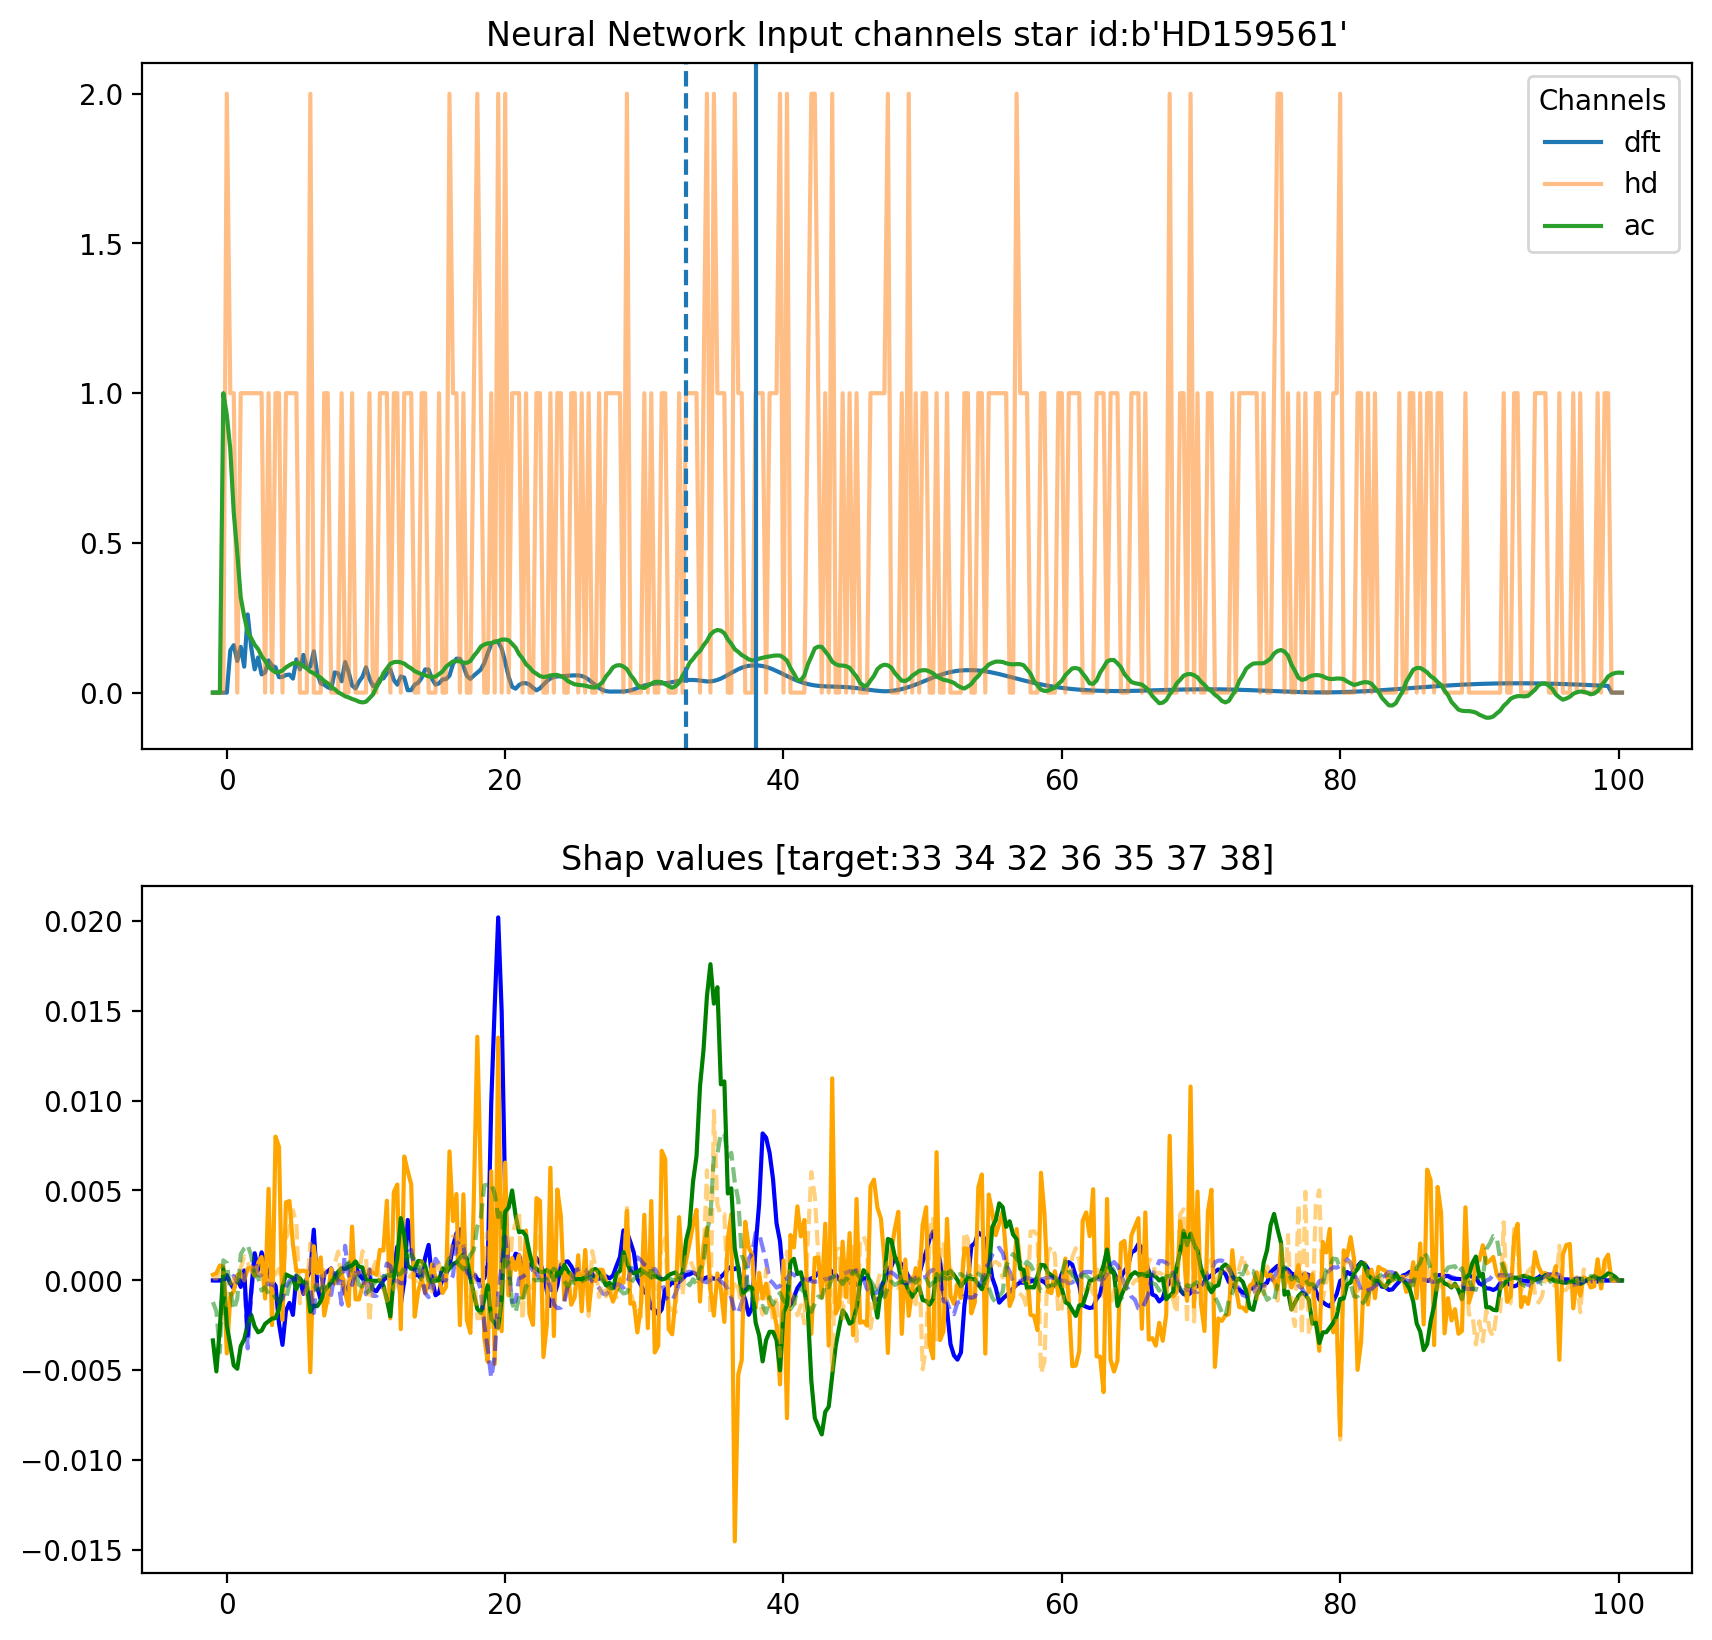

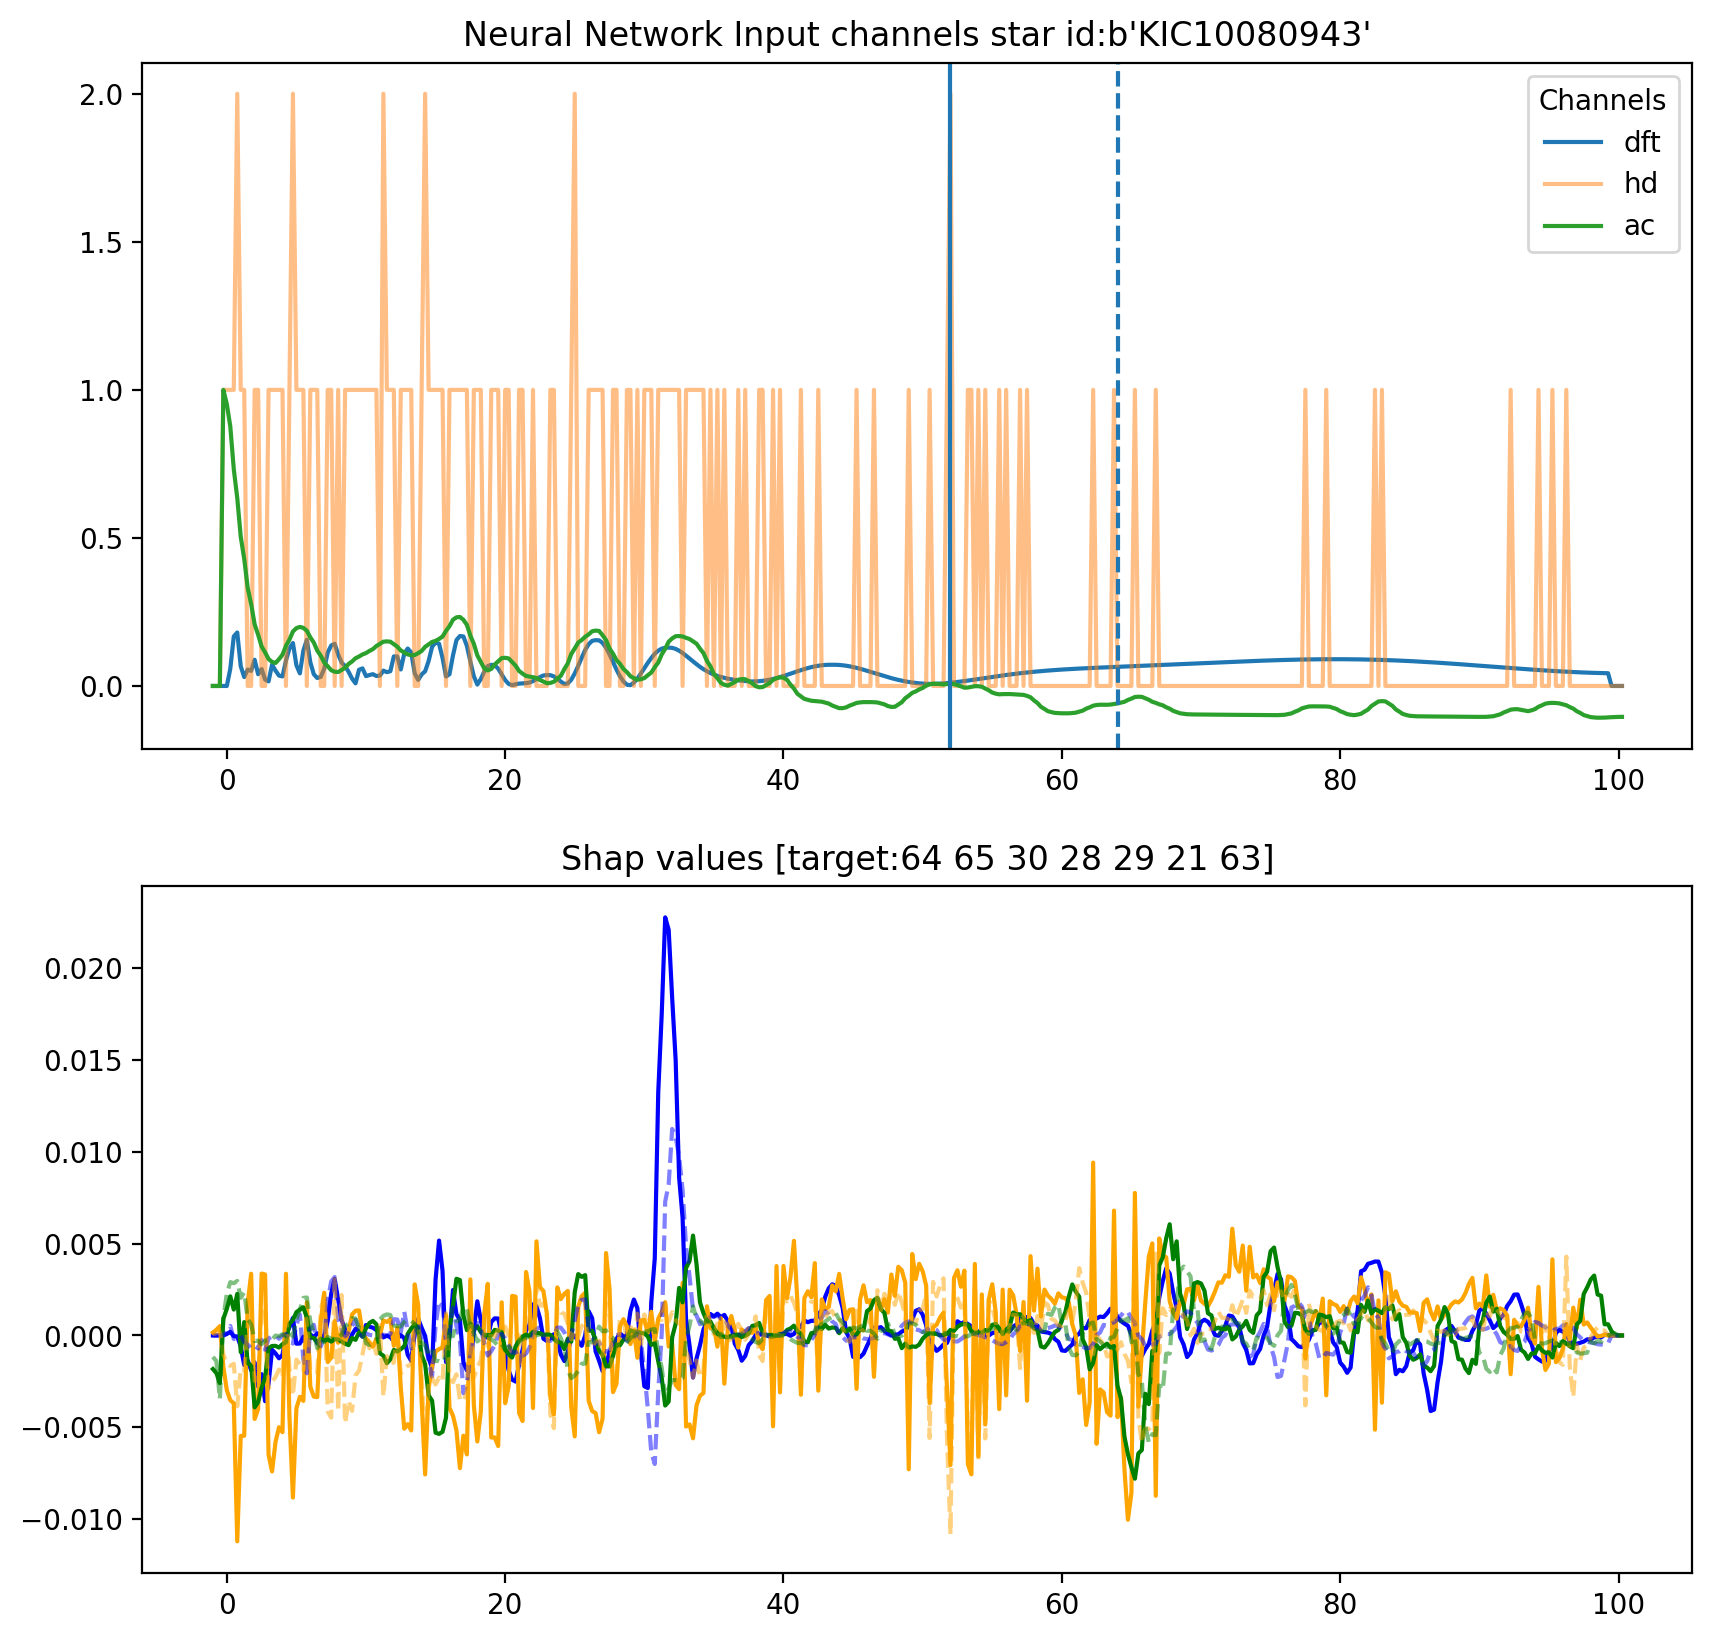

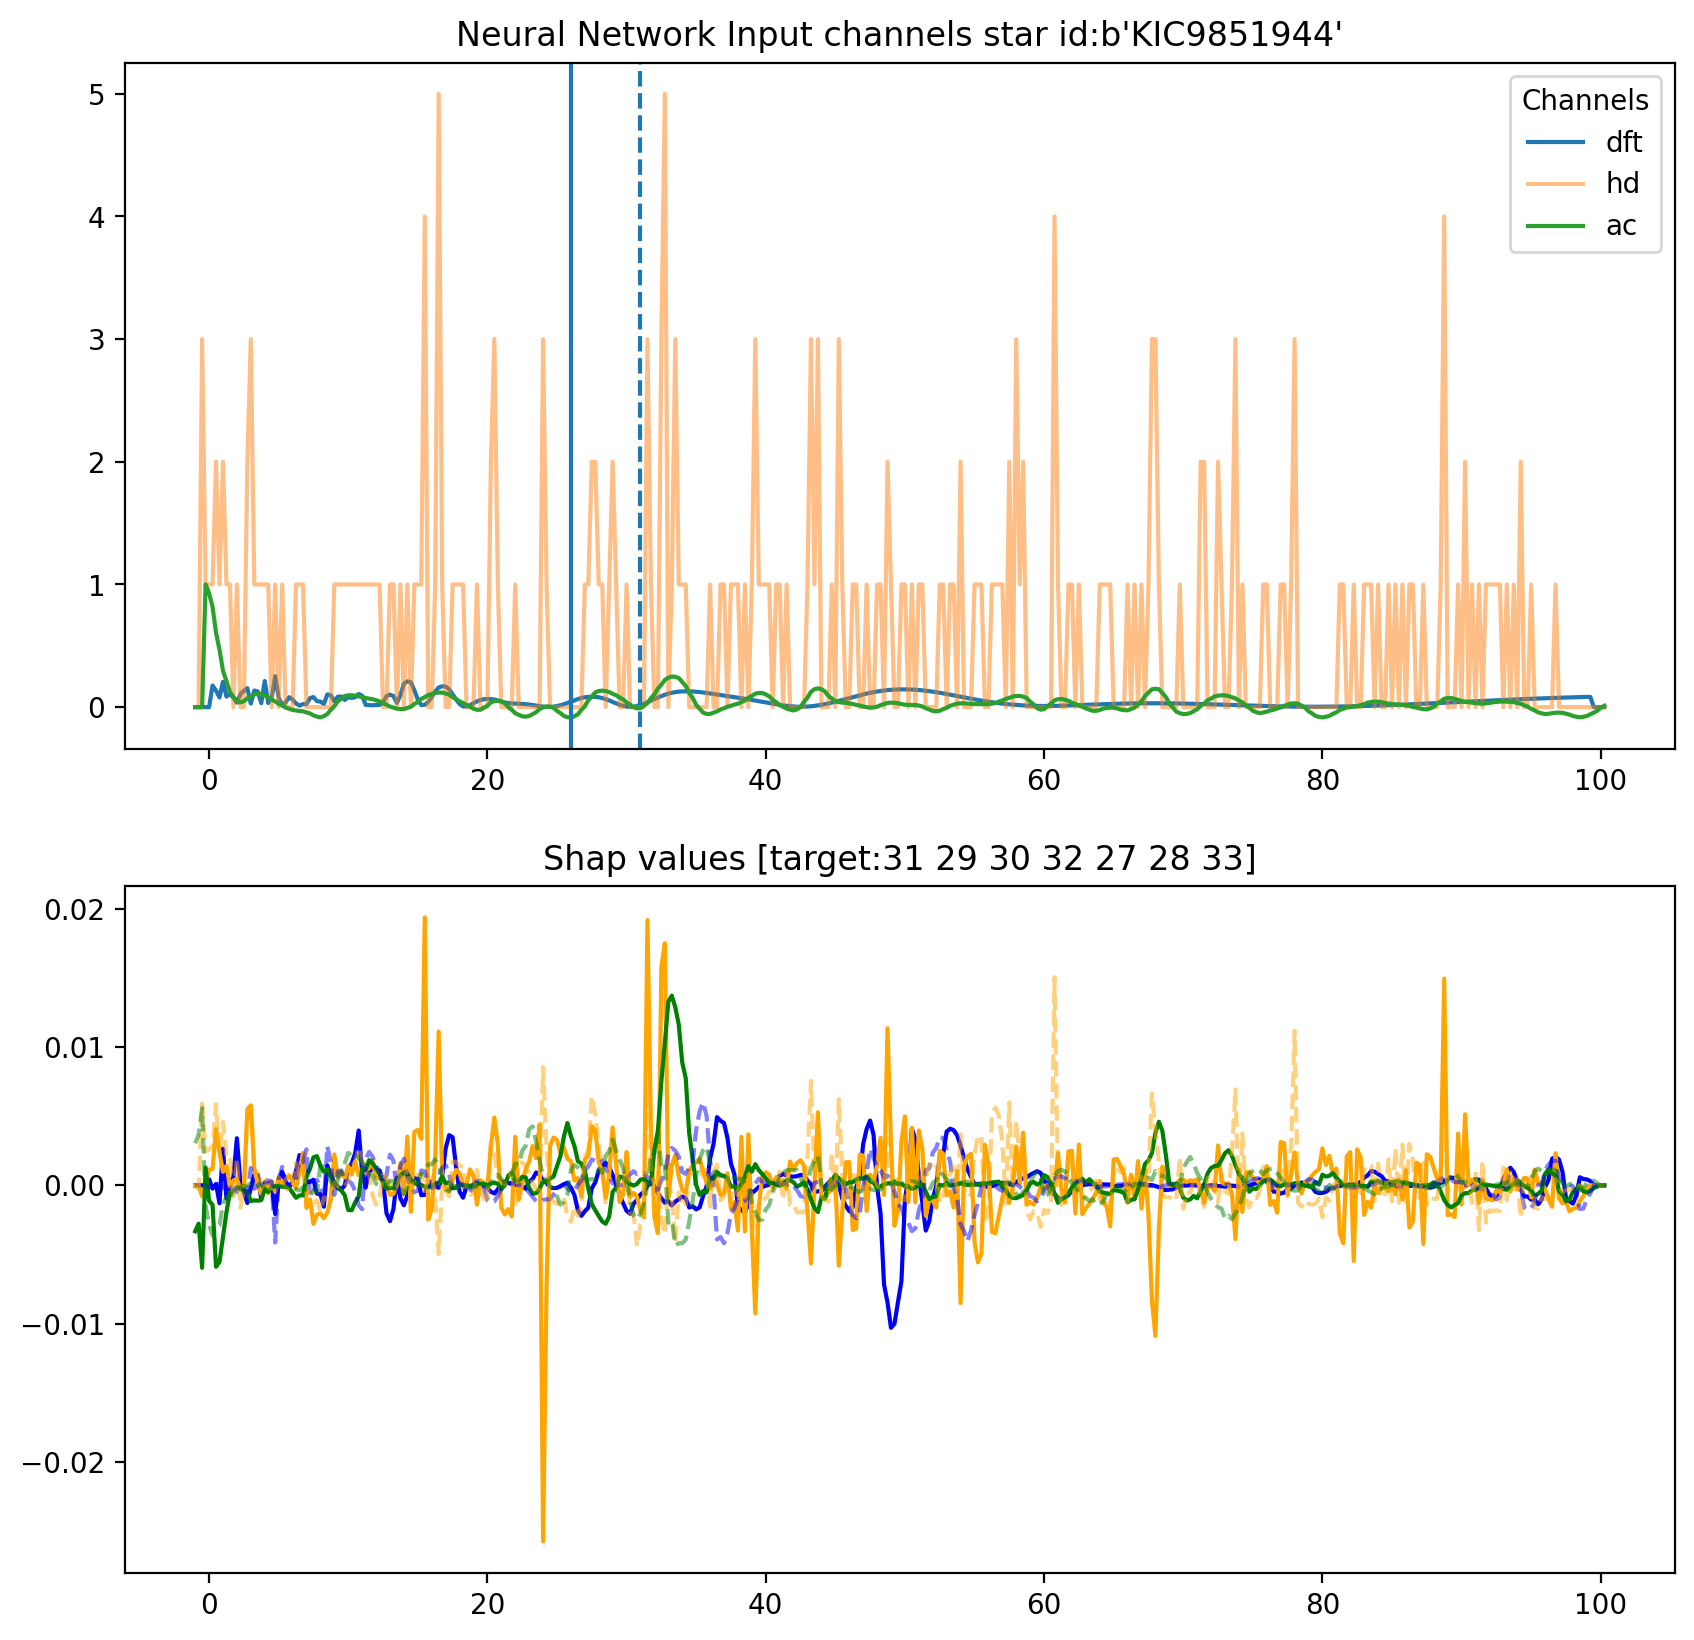

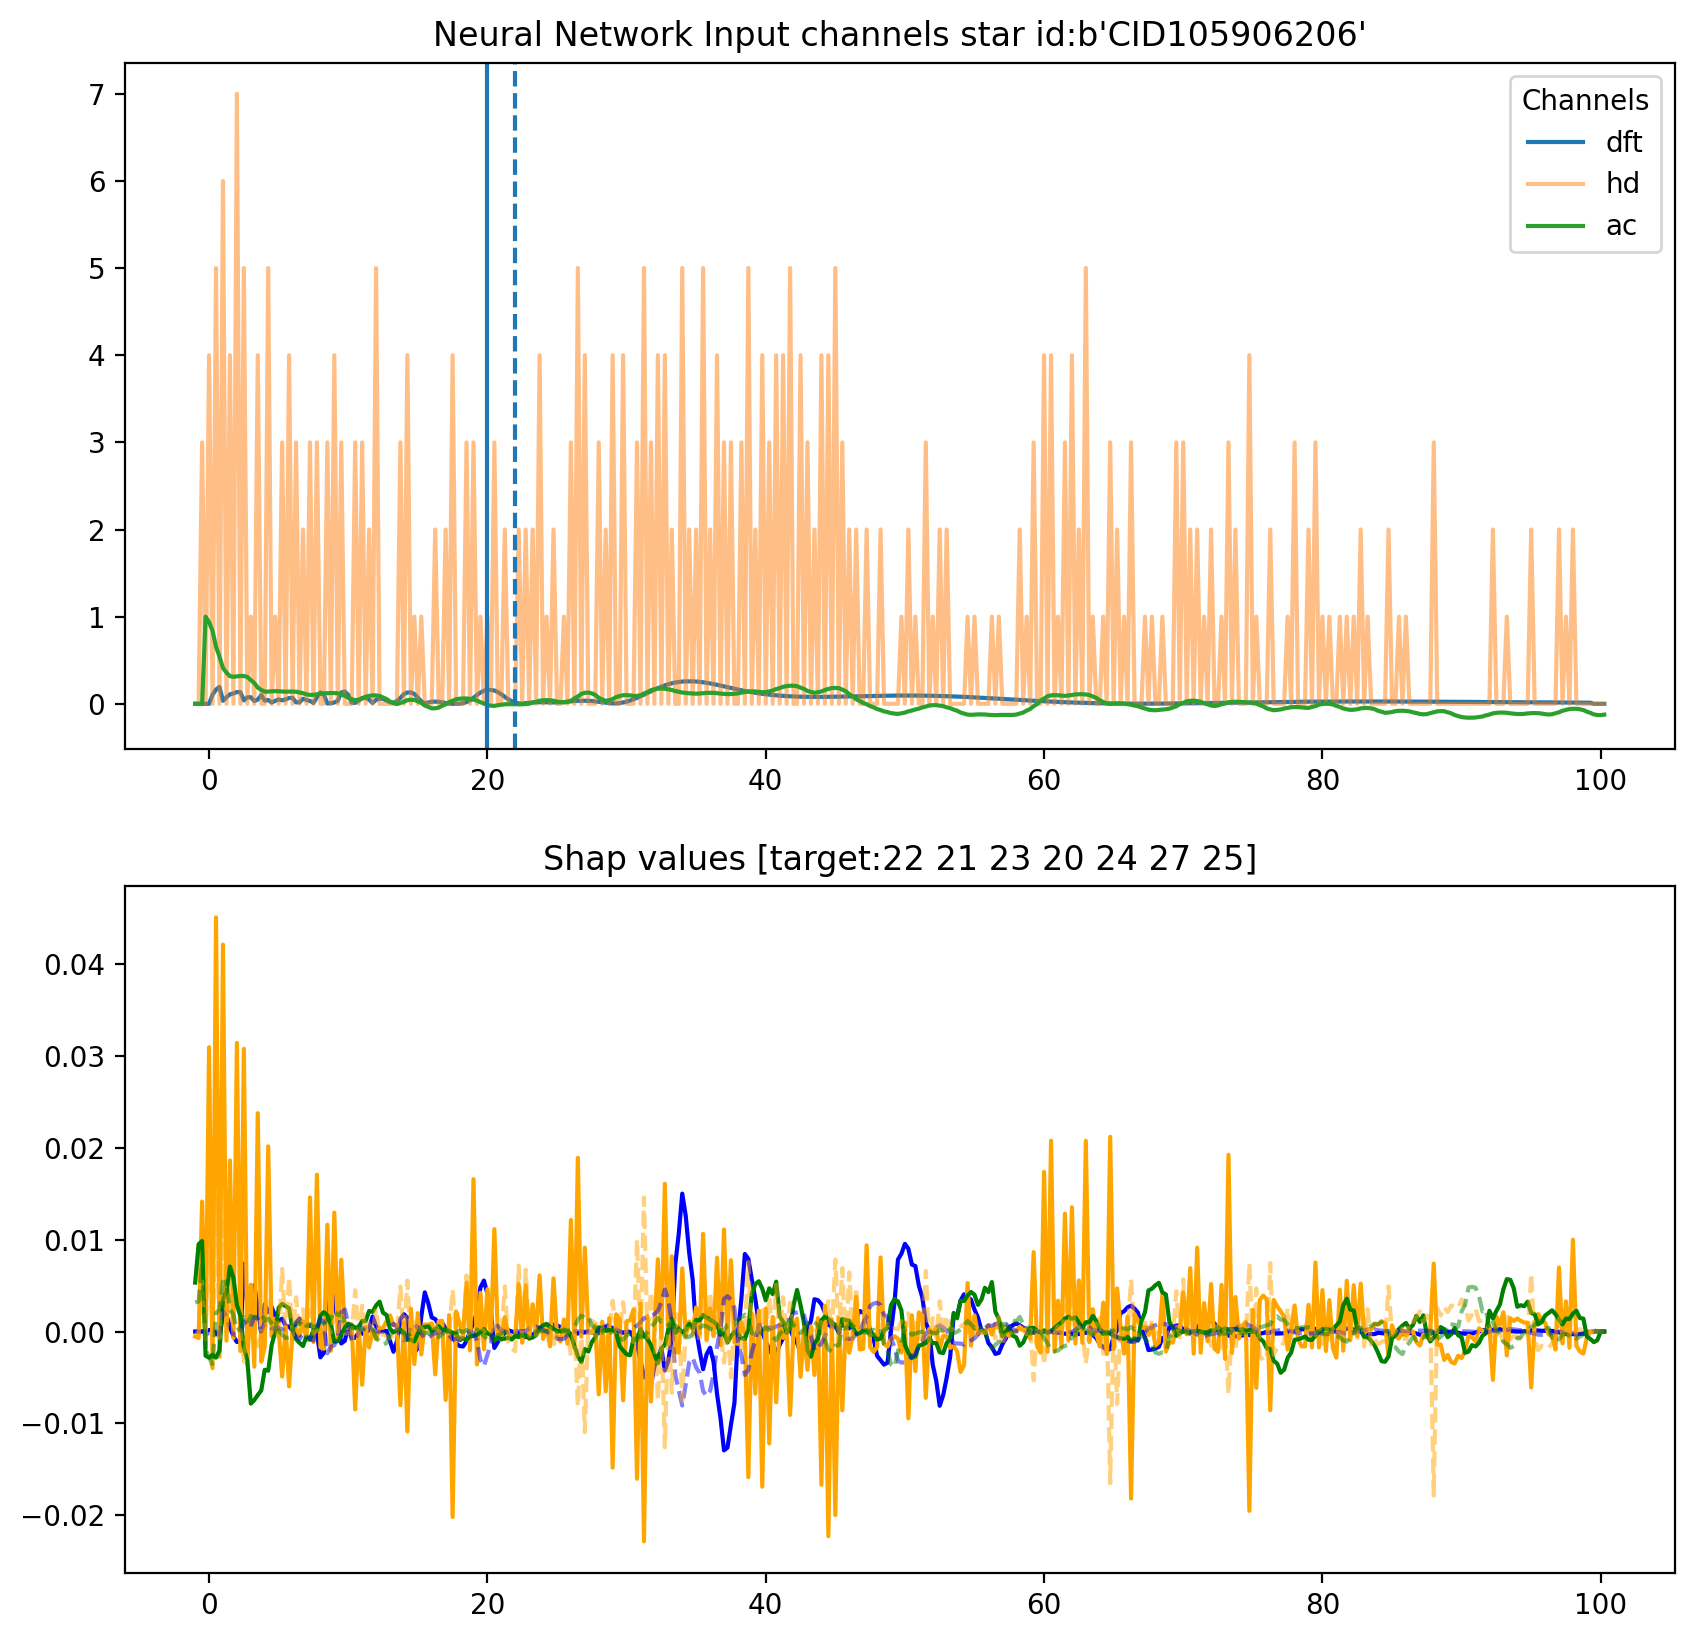

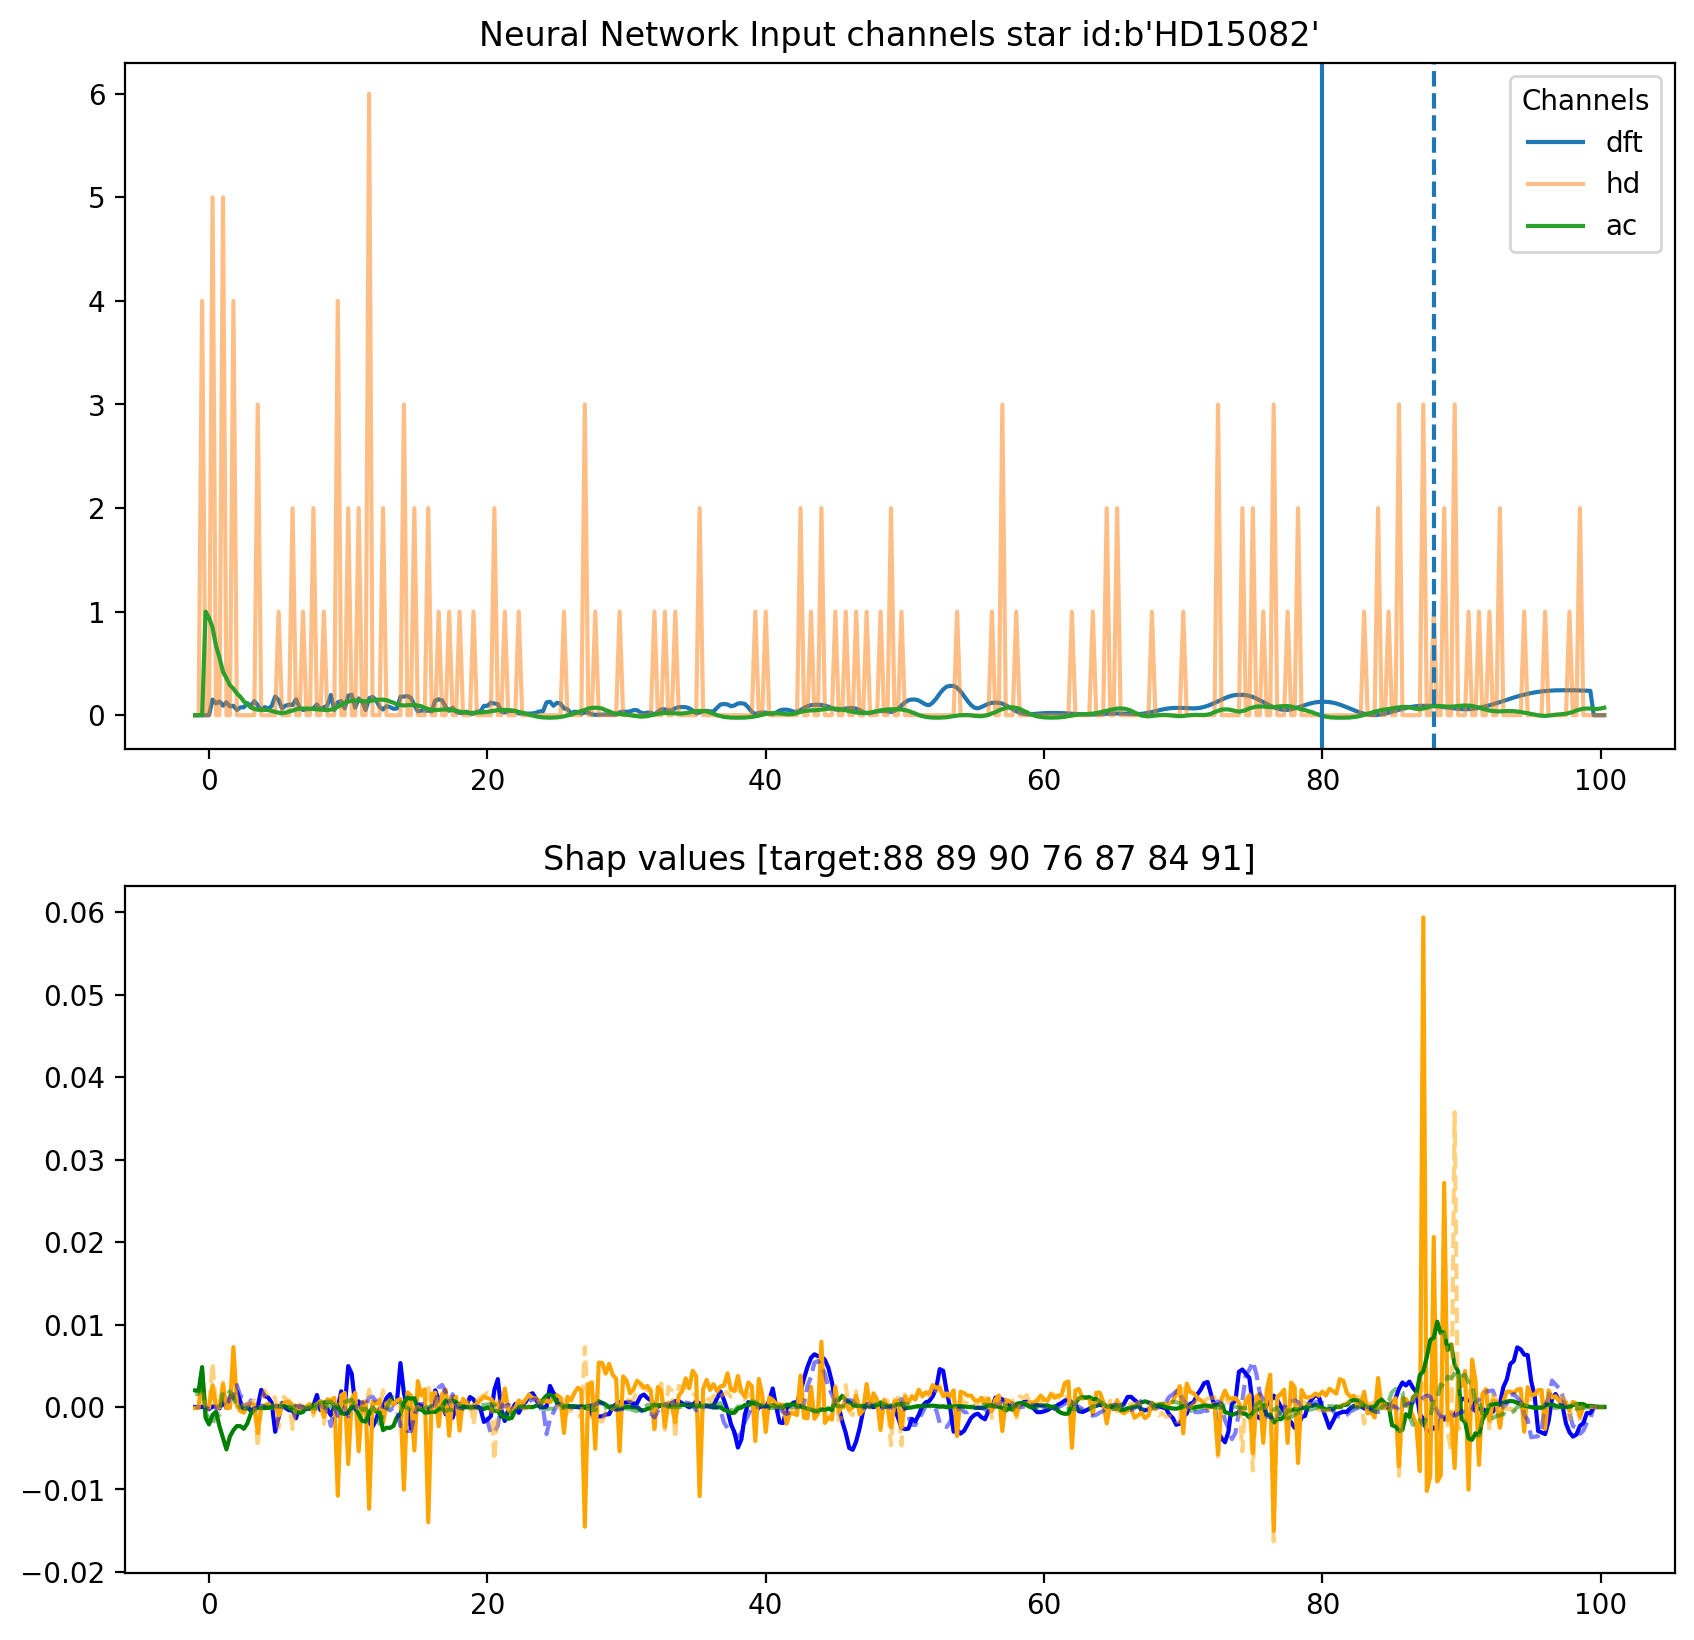

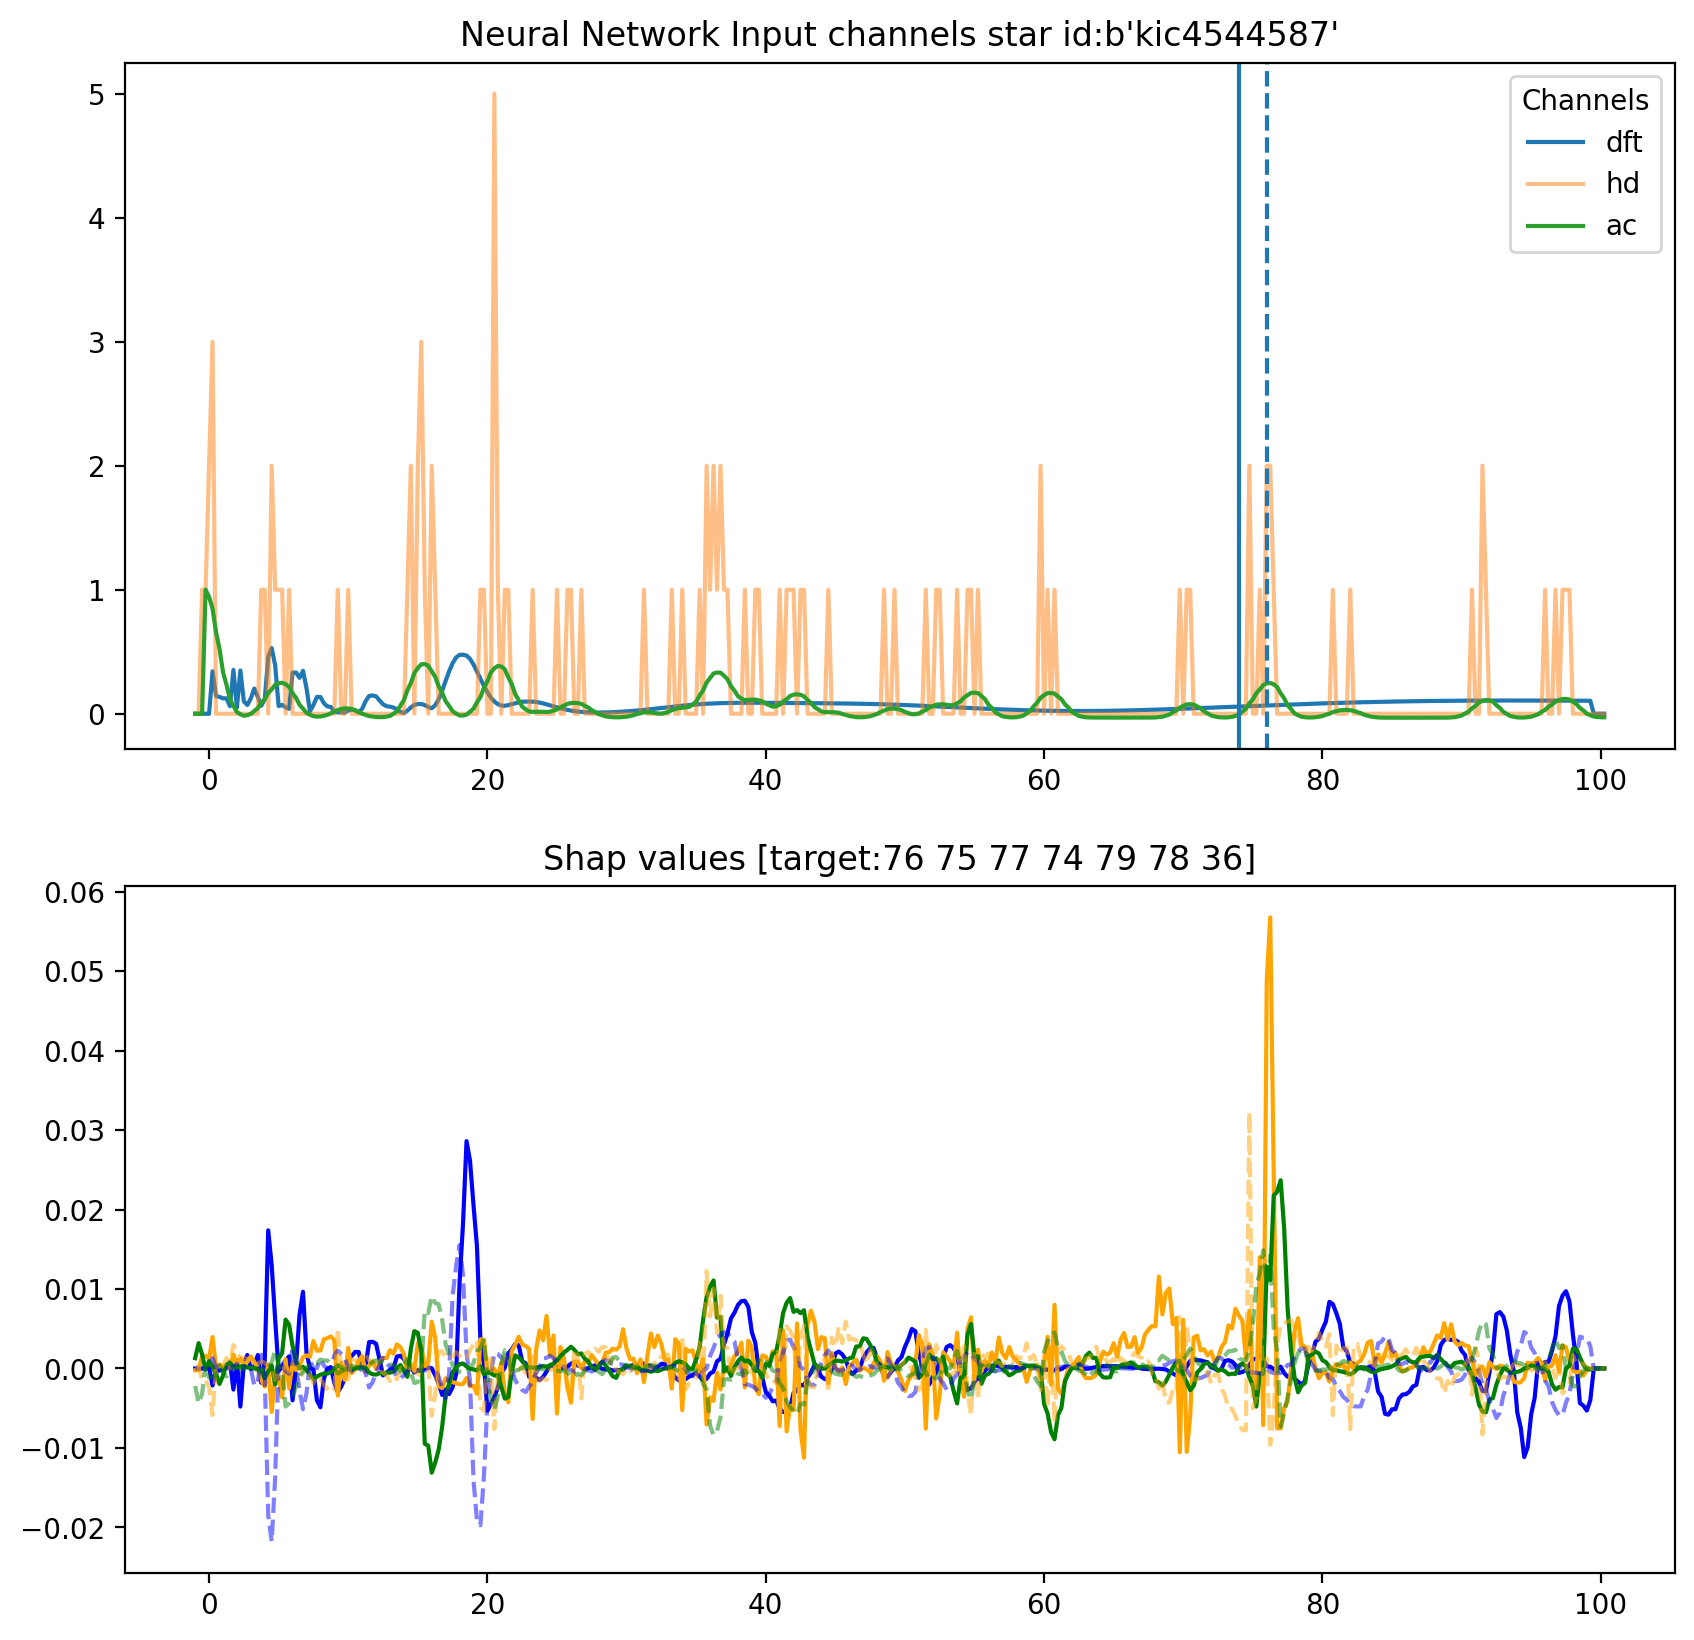

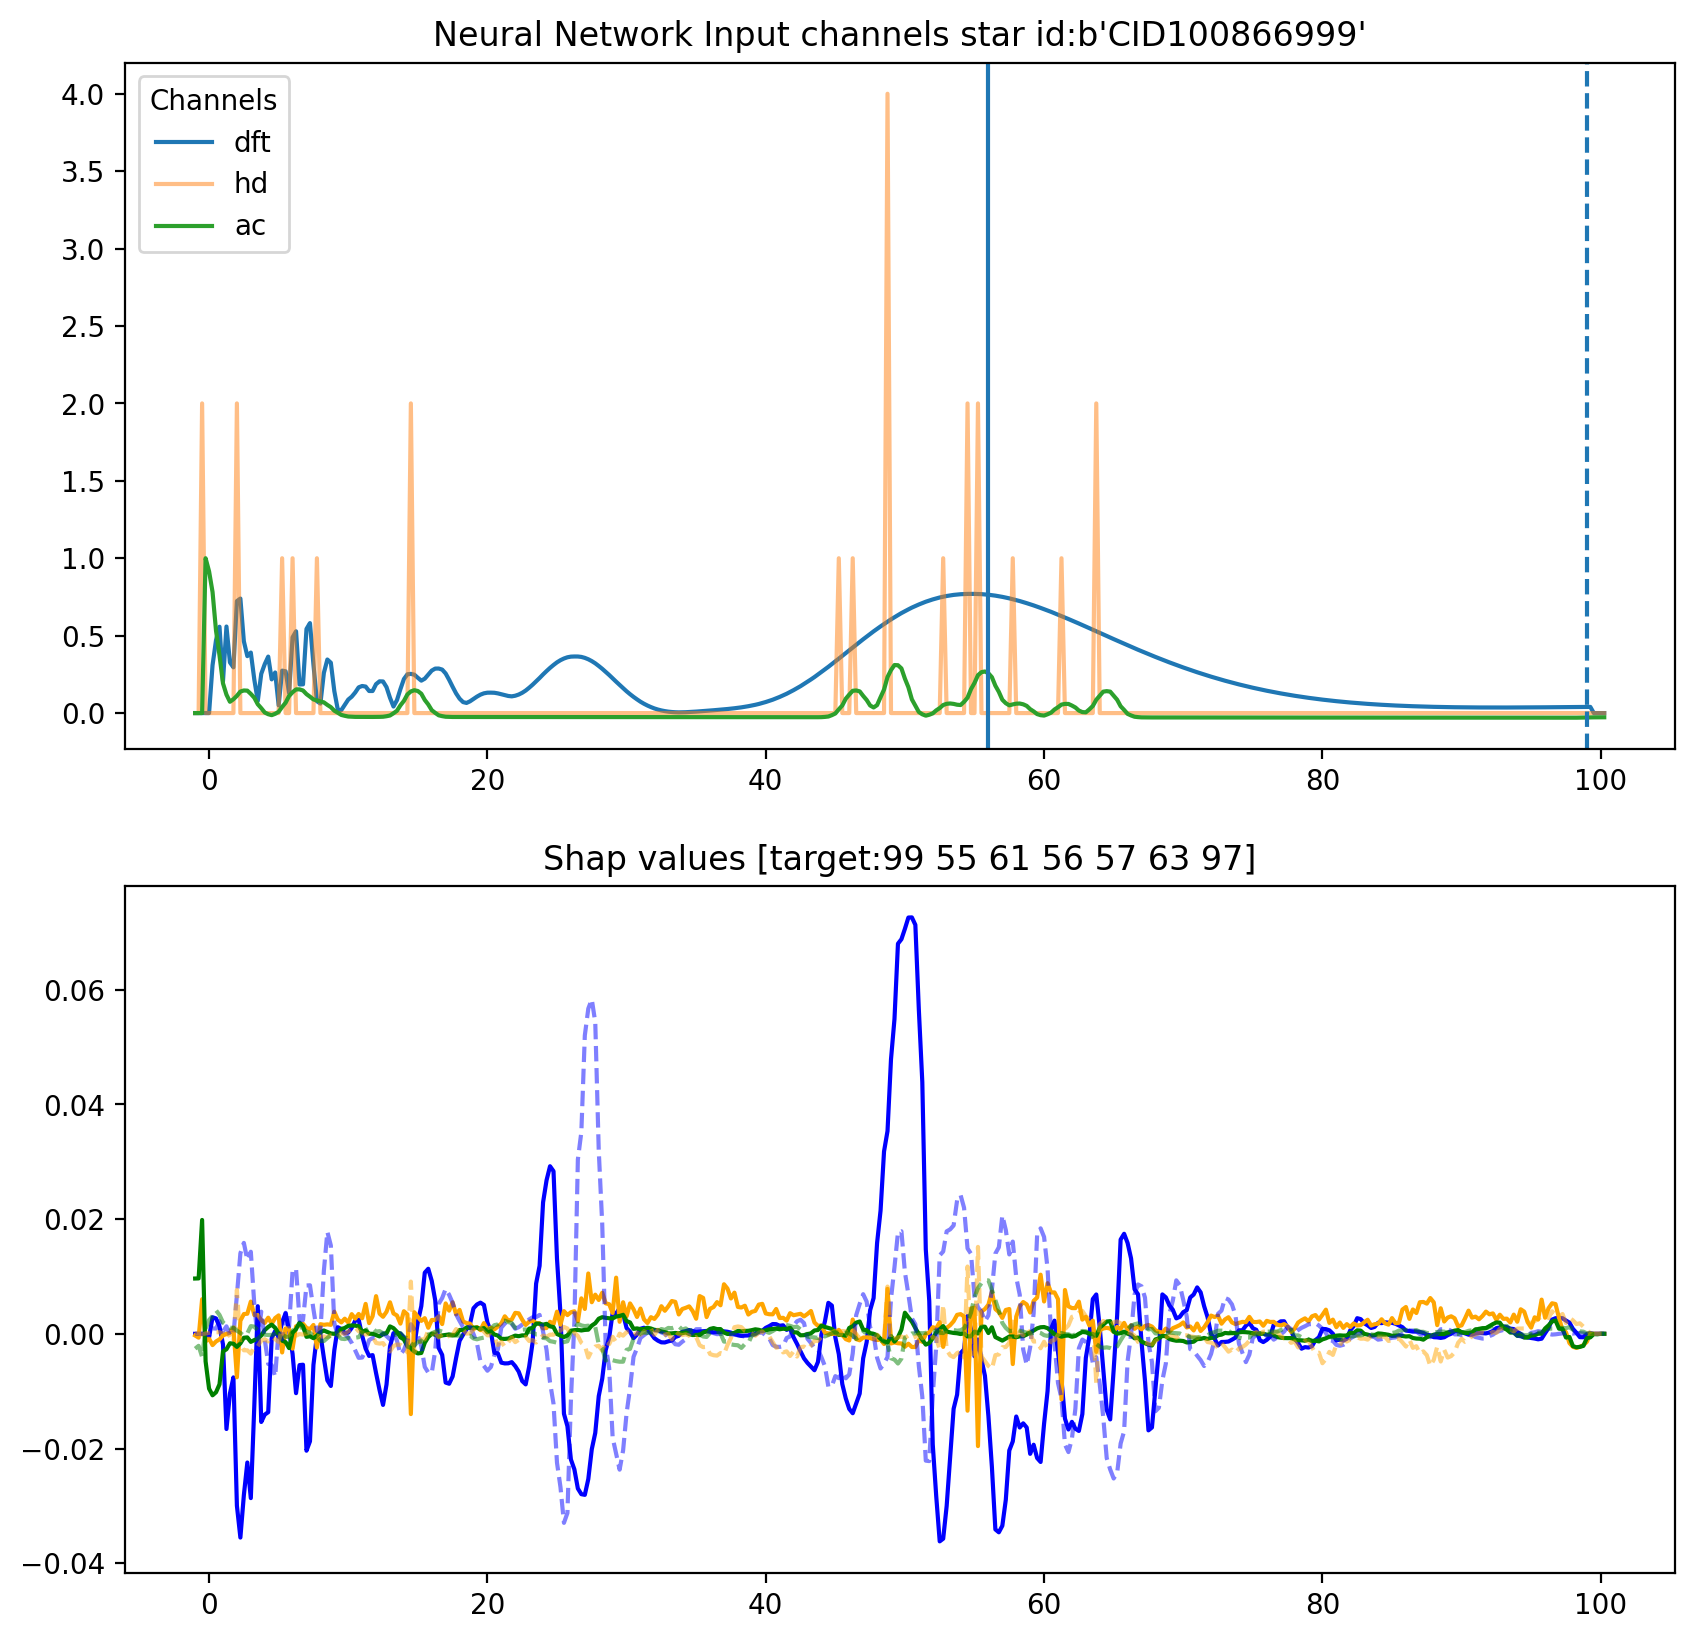

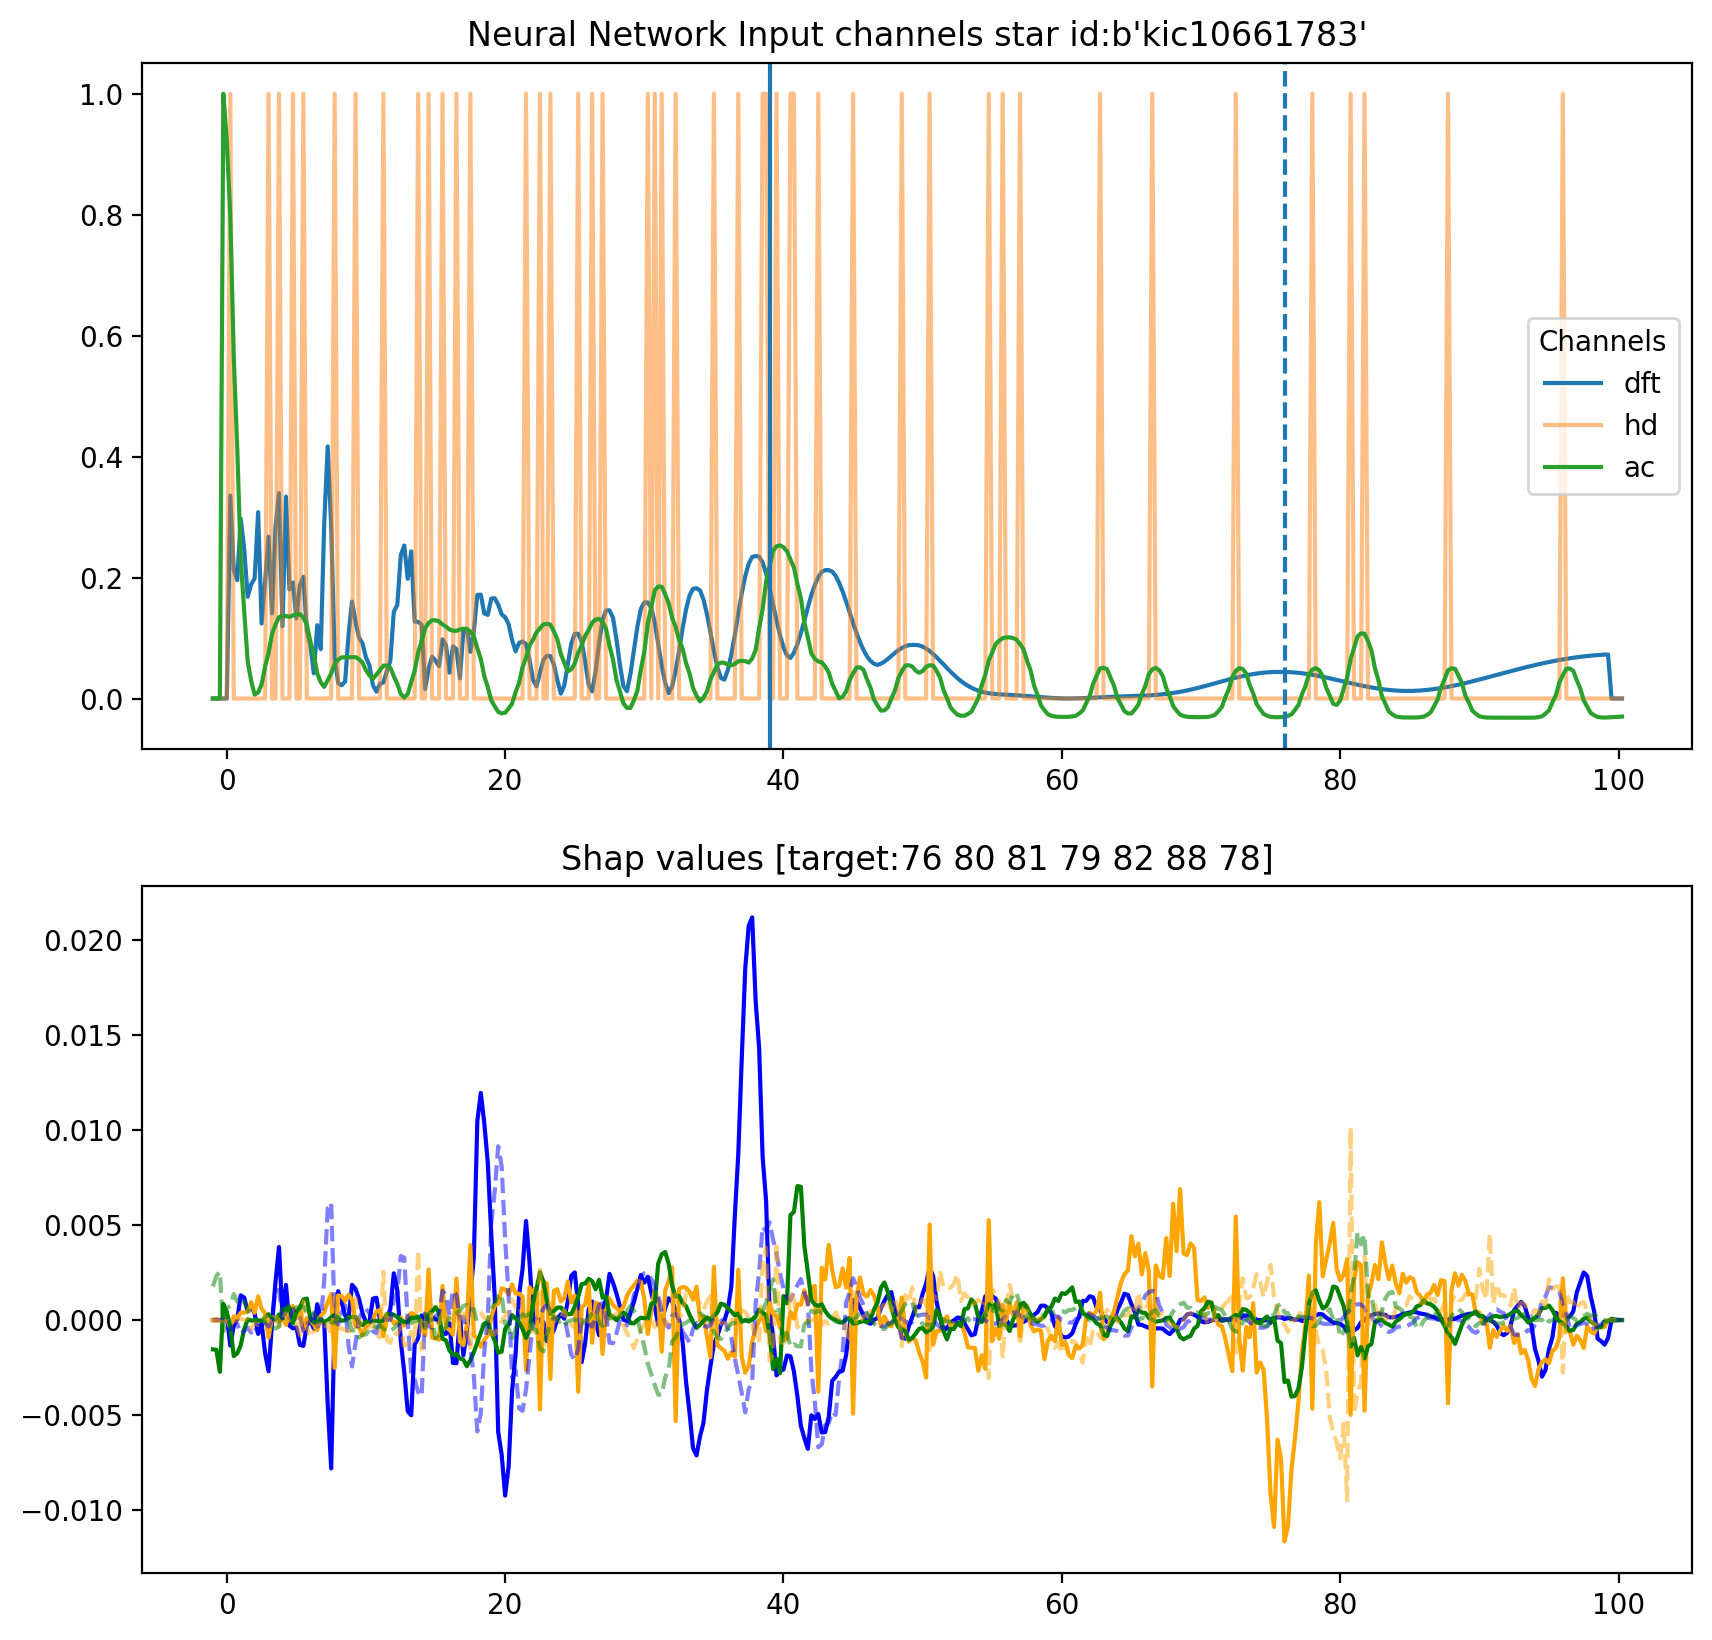

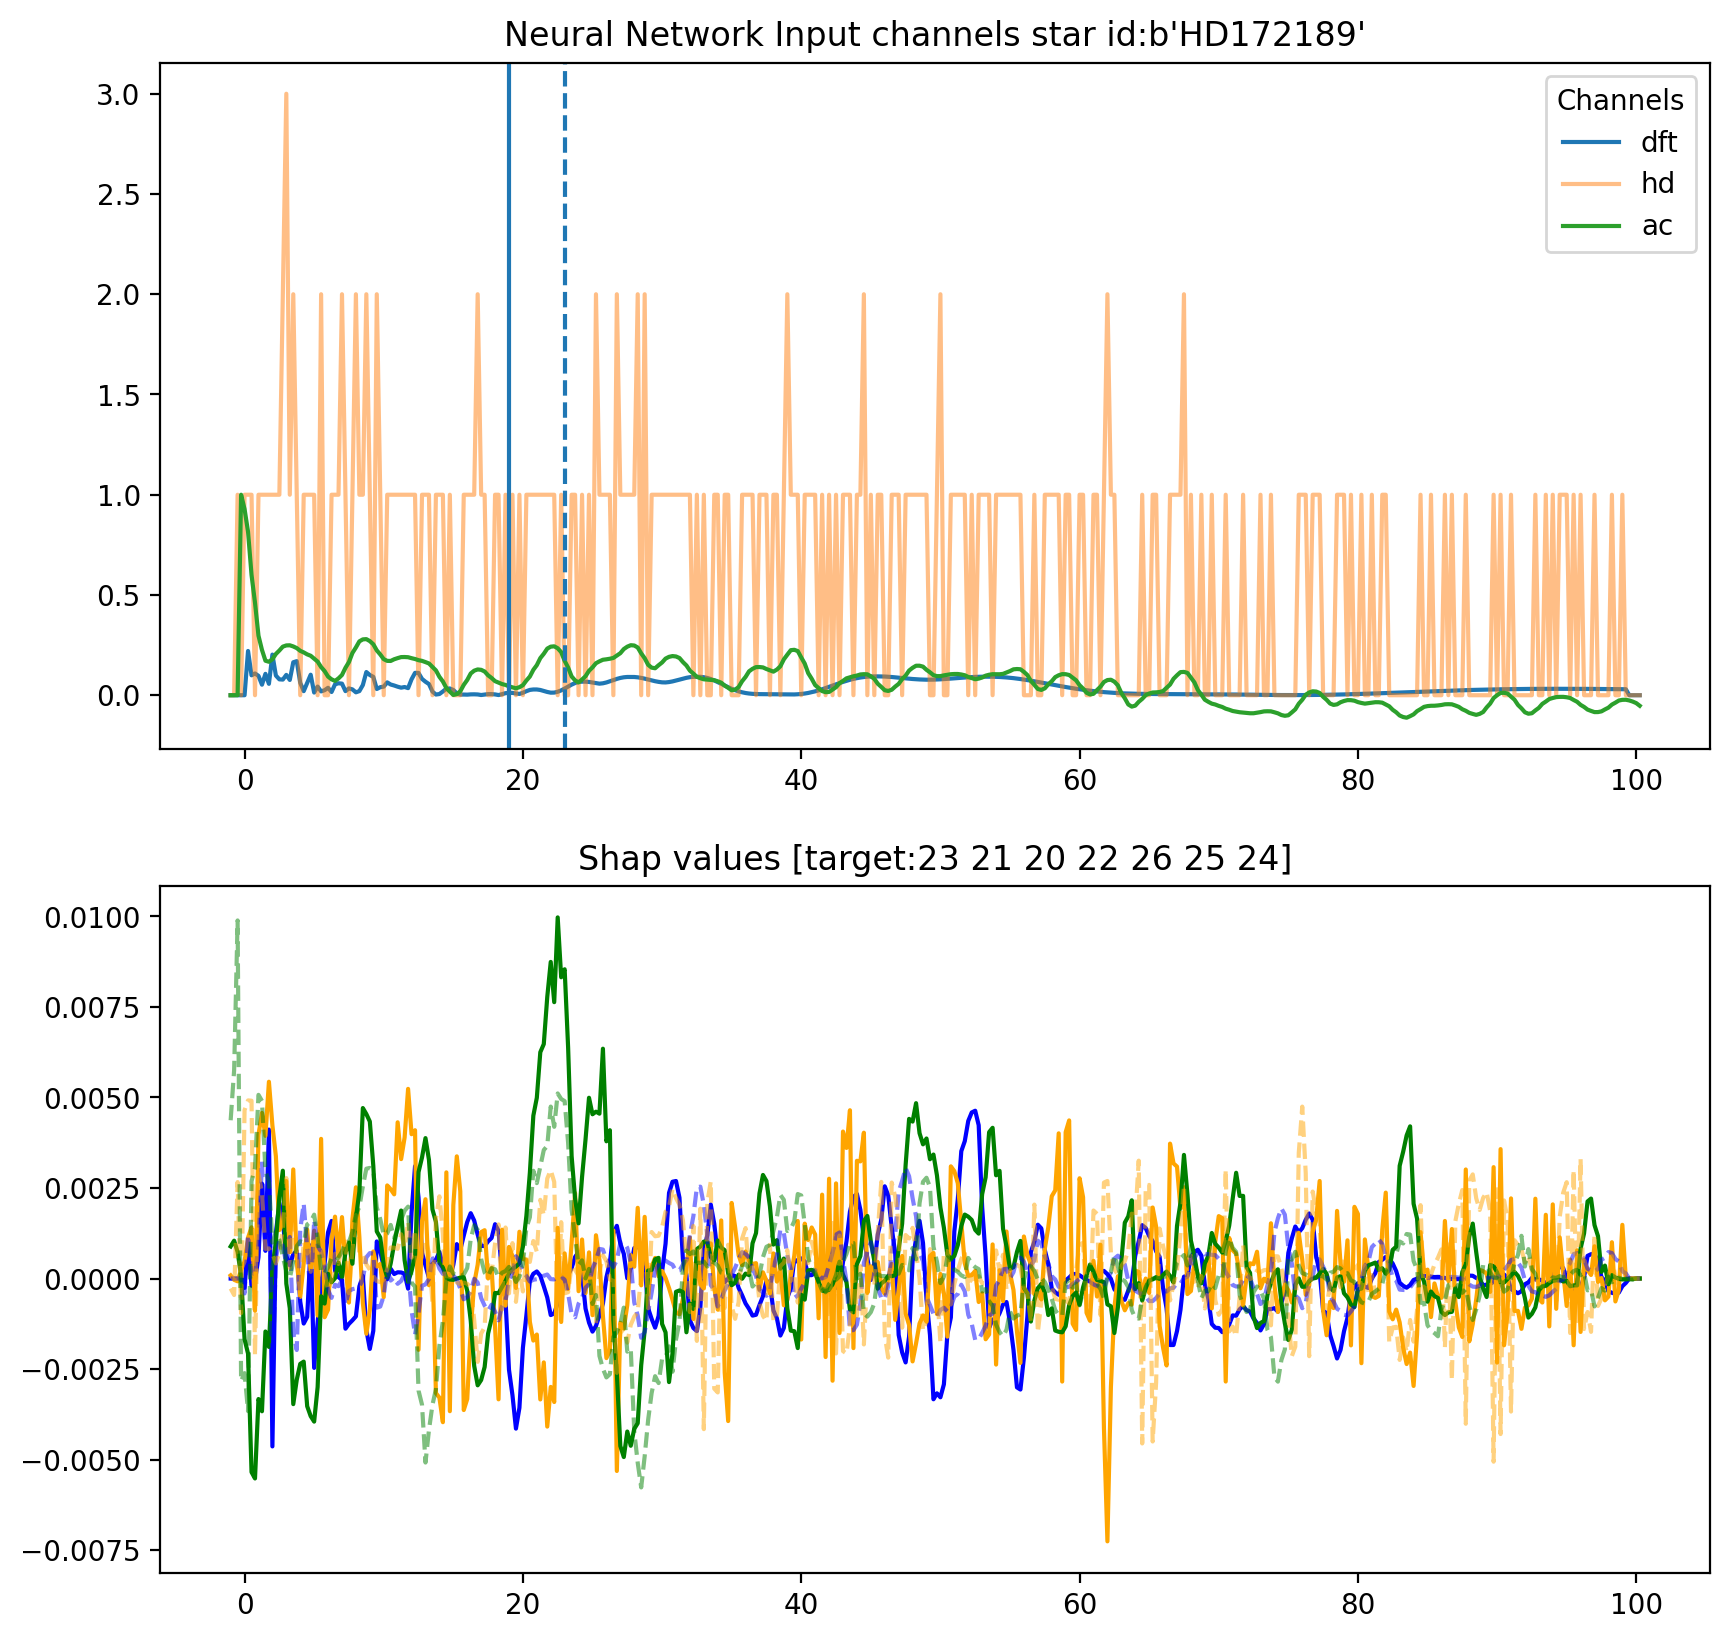

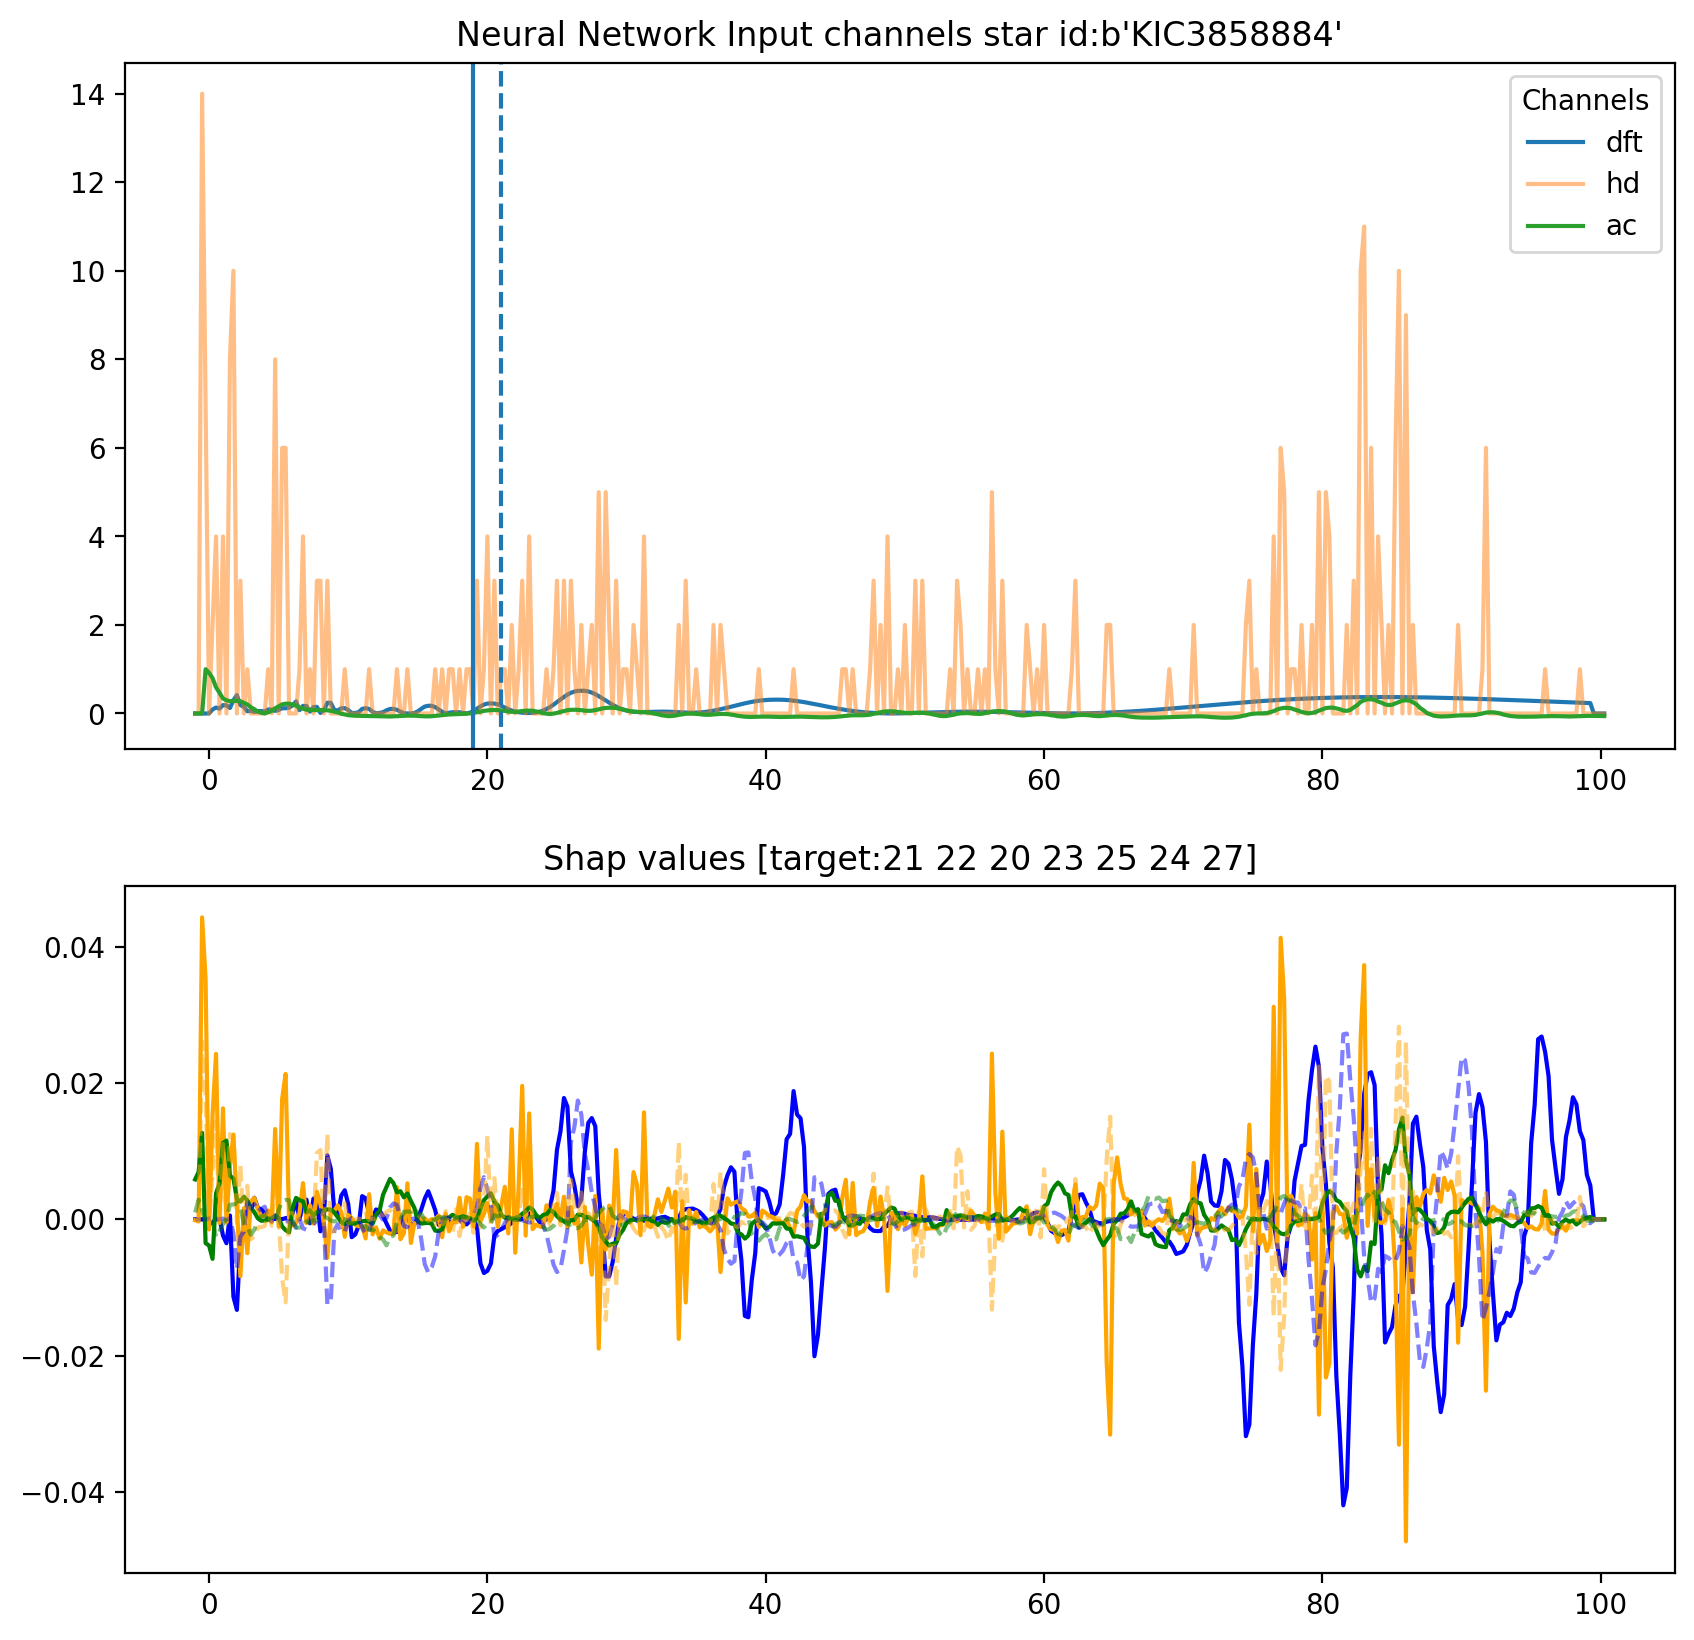

In [5]:
# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
# Load model
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_99")

x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Plot information about ds star
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), dpi=200)
    ax1.plot(x, star[1][0, :, 0].numpy(), label="dft")
    ax1.plot(x, star[1][0, :, 1].numpy(), alpha=0.5, label="hd")
    ax1.plot(x, star[1][0, :, 2].numpy(), label="ac")
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    ax1.axvline(x=target)
    ax1.axvline(x=sepconv_mod.predict_classes(star[1]), linestyle="--")
    # Calculate gradient explainers and shap values
    e = shap.GradientExplainer(
        sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
    )
    shap_values, indexes = e.shap_values(
        star[1].numpy(), nsamples=100, ranked_outputs=10
    )
    print(indexes)
    # Plot shap
    ax2.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
    ax2.plot(
        x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
    )
    ax2.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
    ax2.plot(
        x,
        shap_values[1][0][:, [0]],
        label="dft",
        linestyle="--",
        color="blue",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [1]],
        label="hd",
        linestyle="--",
        color="orange",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [2]],
        label="ac",
        linestyle="--",
        color="green",
        alpha=0.5,
    )

    ax1.legend(title="Channels")
    ax1.title.set_text("Neural Network Input channels" + " star id:" + str(star[0].numpy()[0]))
    ax2.title.set_text(
        "Shap values"
        + " [target:"
        + str(indexes[0][0])
        + " "
        + str(indexes[0][1])
        + " "
        + str(indexes[0][2])
        + " "
        + str(indexes[0][3])
        + " "
        + str(indexes[0][4])
        + " "
        + str(indexes[0][5])
        + " "
        + str(indexes[0][6])
        + "]"
    )
    fig.show()

In [6]:
cid = None
for star in df.take(11):  # take the 11 ds stars
    print(str(star[0].numpy()[0]))
    if star[0].numpy()[0].decode("utf-8") == 'CID100866999':
        cid = star

b'KIC9851944'
b'HD159561'
b'HD15082'
b'KIC10080943'
b'HD172189'
b'CID100866999'
b'KIC3858884'
b'kic10661783'
b'kic4544587'
b'CID105906206'
b'KIC8262223'


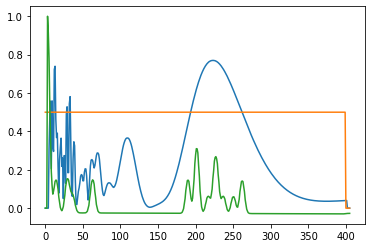

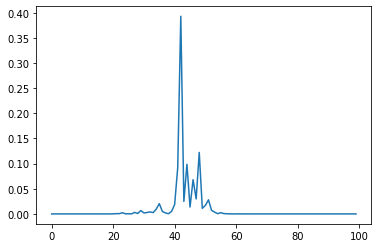

In [7]:
x = cid[1].numpy()
x[0, 0:400, 1] = 0.5
#x[0, 0:400, 2] = 1

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()
plt.plot(sepconv_mod.predict_proba(x)[0][0:100])
plt.show()